<a href="https://colab.research.google.com/github/Aisha-Hagar/Semantic-Segmentation/blob/main/Semantic_Segmanetation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
from shutil import copy
import tensorflow as tf
from tensorflow import image as tf_image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.optimizers import RMSprop, schedules, Adam
import matplotlib.pyplot as plt
import numpy as np

In [2]:
random.seed(765)
tf.random.set_seed(432)

In [3]:
from google.colab import files
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mohammednomer/semantic-segmentation

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
100% 68.7M/68.7M [00:00<00:00, 103MB/s]
100% 68.7M/68.7M [00:00<00:00, 108MB/s]


In [4]:
! mkdir data
! unzip semantic-segmentation.zip -d data

Archive:  semantic-segmentation.zip
  inflating: data/About Acme AI.txt  
  inflating: data/COCO_Football Pixel.json  
  inflating: data/Frame 1  (1).jpg   
  inflating: data/Frame 1  (1).jpg___fuse.png  
  inflating: data/Frame 1  (1).jpg___save.png  
  inflating: data/Frame 1  (10).jpg  
  inflating: data/Frame 1  (10).jpg___fuse.png  
  inflating: data/Frame 1  (10).jpg___save.png  
  inflating: data/Frame 1  (100).jpg  
  inflating: data/Frame 1  (100).jpg___fuse.png  
  inflating: data/Frame 1  (100).jpg___save.png  
  inflating: data/Frame 1  (11).jpg  
  inflating: data/Frame 1  (11).jpg___fuse.png  
  inflating: data/Frame 1  (11).jpg___save.png  
  inflating: data/Frame 1  (12).jpg  
  inflating: data/Frame 1  (12).jpg___fuse.png  
  inflating: data/Frame 1  (12).jpg___save.png  
  inflating: data/Frame 1  (13).jpg  
  inflating: data/Frame 1  (13).jpg___fuse.png  
  inflating: data/Frame 1  (13).jpg___save.png  
  inflating: data/Frame 1  (14).jpg  
  inflating: data/Frame 1 

In [5]:
def create_folders(path):
  try:
    os.makedirs(path)
  except FileExistsError:
    pass

In [6]:
create_folders('train')
create_folders('val')
create_folders('test')

create_folders('train_seg')
create_folders('val_seg')
create_folders('test_seg')

In [7]:
#Generate 100 random numbers between 1 and 100
randomlist=random.sample(list(range(1, 101)), 100)
print(randomlist)

[5, 62, 32, 54, 36, 23, 24, 13, 68, 78, 7, 80, 51, 90, 33, 95, 35, 17, 52, 50, 92, 55, 25, 58, 99, 34, 87, 44, 12, 18, 93, 38, 86, 76, 41, 69, 43, 72, 98, 16, 89, 46, 83, 59, 57, 27, 66, 42, 45, 77, 47, 70, 6, 15, 63, 9, 4, 48, 64, 75, 28, 56, 29, 60, 96, 85, 49, 53, 8, 84, 73, 97, 91, 39, 22, 19, 74, 14, 21, 30, 88, 65, 81, 79, 37, 40, 61, 3, 1, 67, 31, 100, 94, 82, 71, 10, 20, 26, 2, 11]


In [8]:
def copy_images(dstn, dstn_seg, r1, r2):
  for i in range(r1, r2):
    this_image = 'data/Frame 1  ('+str(randomlist[i])+').jpg'
    copy(this_image, dstn)
    this_image = 'data/Frame 1  ('+str(randomlist[i])+').jpg___fuse.png'
    copy(this_image, dstn_seg)

In [9]:
copy_images('train', 'train_seg', 0, 90)
copy_images('val', 'val_seg', 90, 95)
copy_images('test', 'test_seg', 95, 100)

In [10]:
size = 256
def load_image(dir, path, SIZE=size):
    image = load_img(os.path.join(dir, path))
    image = tf_image.resize(image, (SIZE, SIZE))
    image = img_to_array(image)
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image

def load_data(dir, dir_seg, image_paths, label_paths, SIZE=size):
    images, label_maps = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3)), np.zeros(shape=(len(label_paths), SIZE, SIZE, 3))
    for i, (image_path, label_path) in enumerate(zip(image_paths, label_paths)):
        image, label_map = load_image(dir, image_path, SIZE=SIZE), load_image(dir_seg, label_path, SIZE=SIZE)
        images[i], label_maps[i] = image, label_map
    return images, label_maps

In [11]:
train_list = os.listdir('train')
train_seg_list = os.listdir('train_seg')
train_img, train_seg = load_data('train', 'train_seg', train_list, train_seg_list)

val_list = os.listdir('val')
val_seg_list = os.listdir('val_seg')
val_img, val_seg = load_data('val', 'val_seg', val_list, val_seg_list)

test_list = os.listdir('test')
test_seg_list = os.listdir('test_seg')
test_img, test_seg = load_data('test', 'test_seg', test_list, test_seg_list)

In [12]:
for i, s in zip(train_img, train_seg):
  np.append(train_img,tf_image.flip_left_right(i))
  np.append(train_seg,tf_image.flip_left_right(s))
  np.append(train_img,tf_image.flip_up_down(i))
  np.append(train_seg,tf_image.flip_up_down(s))

In [13]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [14]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   return f, p

In [15]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [16]:
def unet_model():
  inputs = layers.Input(shape=(256,256,3))

   # encoder: contracting path - downsample
   # 1 - downsample
  f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
  f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
  f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
  f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
  bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
  u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
  u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
  u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
  u9 = upsample_block(u8, f1, 64)

   # outputs
  outputs = layers.Conv2D(3, kernel_size=3, padding='same', activation='sigmoid')(u9)

   # unet model with Keras Functional API
  unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

  return unet_model

In [17]:
unet_model = unet_model()
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [18]:
lr_schedule = schedules.ExponentialDecay(initial_learning_rate=2e-5,
                                         decay_steps=10000,
                                         decay_rate=0.9,
                                         staircase=True)

In [19]:
unet_model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=lr_schedule), metrics=['accuracy'])
#unet_model.compile(loss='binary_crossentropy',optimizer=Adam(), metrics=['accuracy'])

In [20]:
epochs = 25
history = unet_model.fit(train_img, train_seg,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(val_img, val_seg))

Epoch 1/25
3/3 [==============================] - 151s 36s/step - loss: 0.7185 - accuracy: 0.5313 - val_loss: 0.6993 - val_accuracy: 0.4952
Epoch 2/25
3/3 [==============================] - 5s 2s/step - loss: 0.7038 - accuracy: 0.5391 - val_loss: 0.6952 - val_accuracy: 0.4998
Epoch 3/25
3/3 [==============================] - 5s 2s/step - loss: 0.6984 - accuracy: 0.5449 - val_loss: 0.6933 - val_accuracy: 0.5036
Epoch 4/25
3/3 [==============================] - 5s 2s/step - loss: 0.6955 - accuracy: 0.5484 - val_loss: 0.6924 - val_accuracy: 0.5028
Epoch 5/25
3/3 [==============================] - 5s 2s/step - loss: 0.6937 - accuracy: 0.5472 - val_loss: 0.6920 - val_accuracy: 0.4989
Epoch 6/25
3/3 [==============================] - 5s 2s/step - loss: 0.6927 - accuracy: 0.5409 - val_loss: 0.6919 - val_accuracy: 0.4921
Epoch 7/25
3/3 [==============================] - 5s 2s/step - loss: 0.6920 - accuracy: 0.5301 - val_loss: 0.6918 - val_accuracy: 0.4843
Epoch 8/25
3/3 [======================

In [21]:
def plot_learning_curves(history, model_name):
  fig, ax = plt.subplots(1, 2, figsize=(16, 8))
  ax[0].plot(history.history['accuracy'])
  ax[0].plot(history.history['val_accuracy'])
  ax[0].set_title(model_name+' accuracy')
  ax[0].set_ylabel('accuracy')
  ax[0].set_xlabel('epoch')
  ax[0].legend(['train', 'validation'], loc='upper right')

  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'])
  ax[1].set_title(model_name+' loss')
  ax[1].set_ylabel('loss')
  ax[1].set_xlabel('epoch')
  ax[1].legend(['train', 'validation'], loc='upper right')

  plt.show()

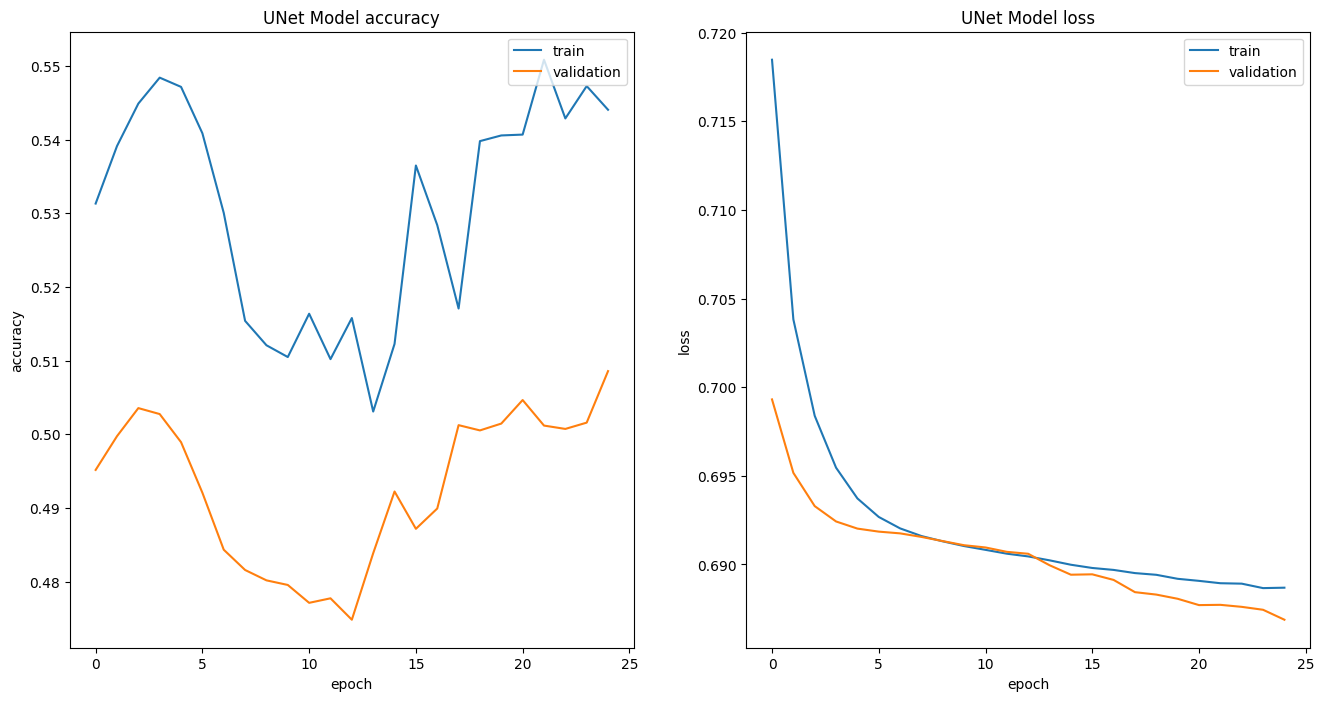

In [22]:
plot_learning_curves(history, 'UNet Model')

In [23]:
test_pred = unet_model.predict(test_img)

1/1 [==============================] - 1s 662ms/step


Text(0.5, 1.0, 'Prediction')

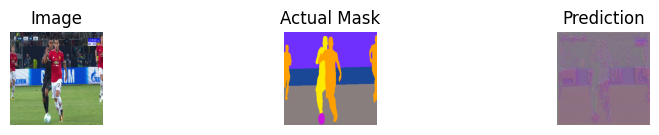

In [26]:
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(5, 3, 1)
plt.imshow(test_img[i])
plt.axis('off')
plt.title('Image')
fig.add_subplot(5, 3, 2)
plt.imshow(test_seg[i])
plt.axis('off')
plt.title('Actual Mask')
fig.add_subplot(5, 3, 3)
plt.imshow(test_pred[i])
plt.axis('off')
plt.title('Prediction')

Resources:

https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/

https://www.kaggle.com/code/utkarshsaxenadn/football-player-segmentation-unet